<a href="https://colab.research.google.com/github/manikur/R-programming/blob/main/Sbin_ns_stock_price_analysis_mathclasstutor_com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
!pip install yfinance

In [119]:
import yfinance as yf
import numpy as np
import os
import random
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import (Dataset, TensorDataset,
 DataLoader, Subset)
from collections import OrderedDict
from sklearn.metrics import mean_squared_error

In [120]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [121]:
df = yf.download('SBIN.NS',
 start='2010-01-01',
 end='2022-04-18',
 adjusted=True,
 progress=False)

In [122]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-07,510.049988,519.900024,510.049988,514.950012,514.950012,19620958
2022-04-08,519.500000,519.500000,512.349976,516.099976,516.099976,13572638
2022-04-11,513.500000,522.000000,513.200012,514.900024,514.900024,12370288
2022-04-12,512.750000,516.700012,504.350006,512.849976,512.849976,14460680
2022-04-13,514.299988,520.900024,513.750000,517.700012,517.700012,15440525


In [123]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000,3.031000e+03
mean,265.607026,269.082131,261.702011,265.233538,255.749833,2.568311e+07
std,76.510785,77.360485,75.569429,76.524856,79.760227,1.978595e+07
min,147.000000,148.490005,145.270004,147.360001,138.993088,0.000000e+00
25%,211.500000,214.845001,208.575005,211.419998,196.638733,1.419952e+07
50%,256.399994,259.500000,253.014999,256.000000,246.487244,1.970000e+07
75%,294.449997,298.000000,290.024994,293.875000,286.380966,2.972203e+07
max,543.950012,549.000000,537.150024,540.549988,540.549988,2.626771e+08


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7321b84f50>,
      dtype=object)

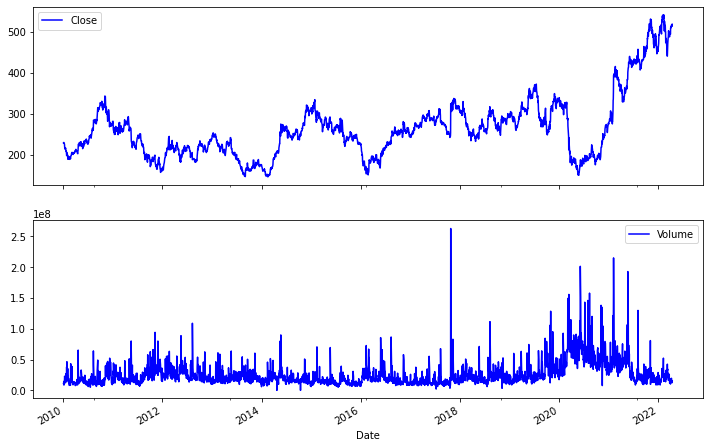

In [124]:
df[['Close', 'Volume']].plot(subplots=True, style='b',
figsize=(12, 8))

In [125]:
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'price'}, inplace=True)
df = df.resample('M').last()

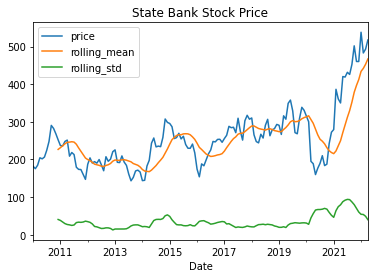

In [126]:
WINDOW_SIZE = 12
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df.plot(title='State Bank Stock Price')

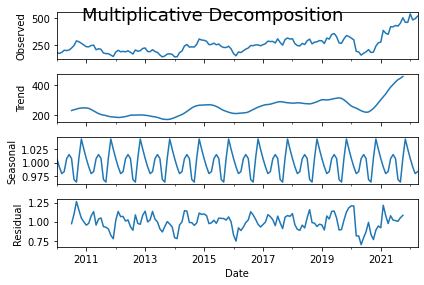

In [127]:
decomposition_results = seasonal_decompose(df.price,
 model='multiplicative')
decomposition_results.plot() \
 .suptitle('Multiplicative Decomposition',
 fontsize=18);

In [128]:
import pandas as pd
import seaborn as sns
from fbprophet import Prophet

In [129]:
df = yf.download('SBIN.NS',
 start='2010-01-01',
 end='2022-04-18',
 adjusted=True,
 progress=False)

In [130]:
df = df.loc[:, ['Adj Close']]

In [131]:
df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

In [132]:
train_indices = df.ds.apply(lambda x: x.year) < 2022
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)

In [133]:
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5,fourier_order=5)
model_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


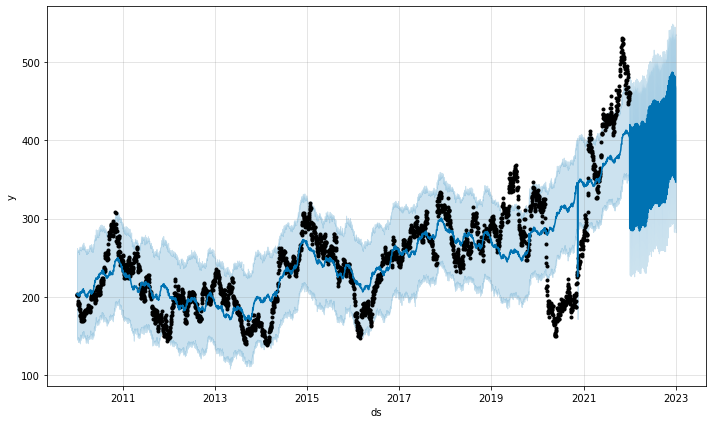

In [134]:
df_future = model_prophet.make_future_dataframe(periods=365)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred);

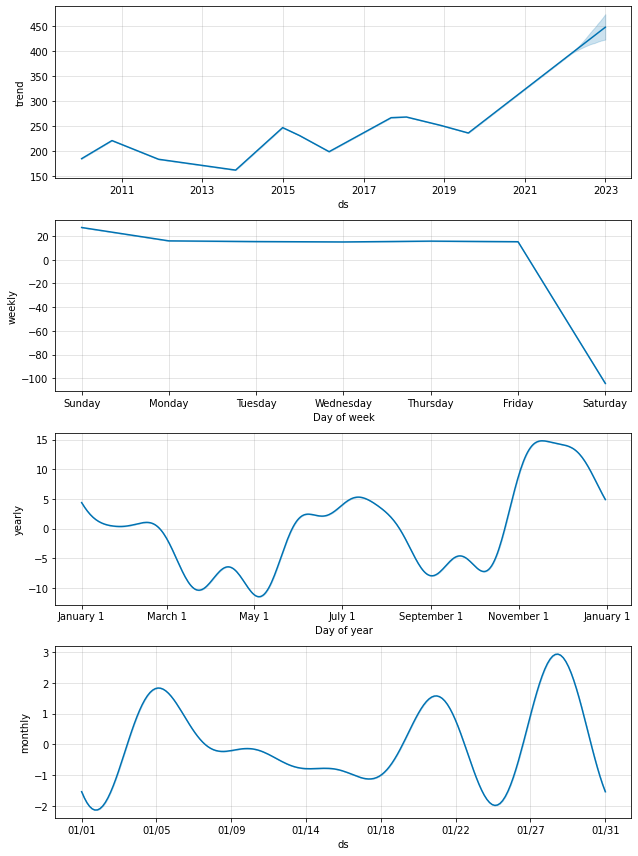

In [135]:
model_prophet.plot_components(df_pred);

In [136]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

In [137]:
df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)

In [138]:
import matplotlib.pyplot as plt

[Text(0, 0.5, 'Stock Price '),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Stock Price - actual vs. predicted')]

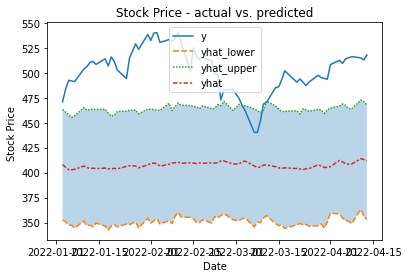

In [139]:
fig, ax = plt.subplots(1, 1)
ax = sns.lineplot(data=df_test[['y', 'yhat_lower', 'yhat_upper','yhat']])
ax.fill_between(df_test.index,
 df_test.yhat_lower,
 df_test.yhat_upper,
 alpha=0.3)
ax.set(title='Stock Price - actual vs. predicted',
 xlabel='Date',
 ylabel='Stock Price ')

In [140]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [141]:
def adf_test(x):
 indices = ['Test Statistic', 'p-value',
 '# of Lags Used', '# of Observations Used']
 adf_test = adfuller(x, autolag='AIC')
 results = pd.Series(adf_test[0:4], index=indices)
 for key, value in adf_test[4].items():
  results[f'Critical Value ({key})'] = value
 return results

In [142]:
adf_test(df.y)

Test Statistic              -0.714314
p-value                      0.843007
# of Lags Used               1.000000
# of Observations Used    3029.000000
Critical Value (1%)         -3.432511
Critical Value (5%)         -2.862495
Critical Value (10%)        -2.567278
dtype: float64

In [143]:
def kpss_test(x, h0_type='c'):
 indices = ['Test Statistic', 'p-value', '# of Lags']
 kpss_test = kpss(x, regression=h0_type)
 results = pd.Series(kpss_test[0:3], index=indices)
 for key, value in kpss_test[3].items():
  results[f'Critical Value ({key})'] = value
 return results

In [144]:
kpss_test(df.y)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test Statistic            4.480838
p-value                   0.010000
# of Lags                29.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

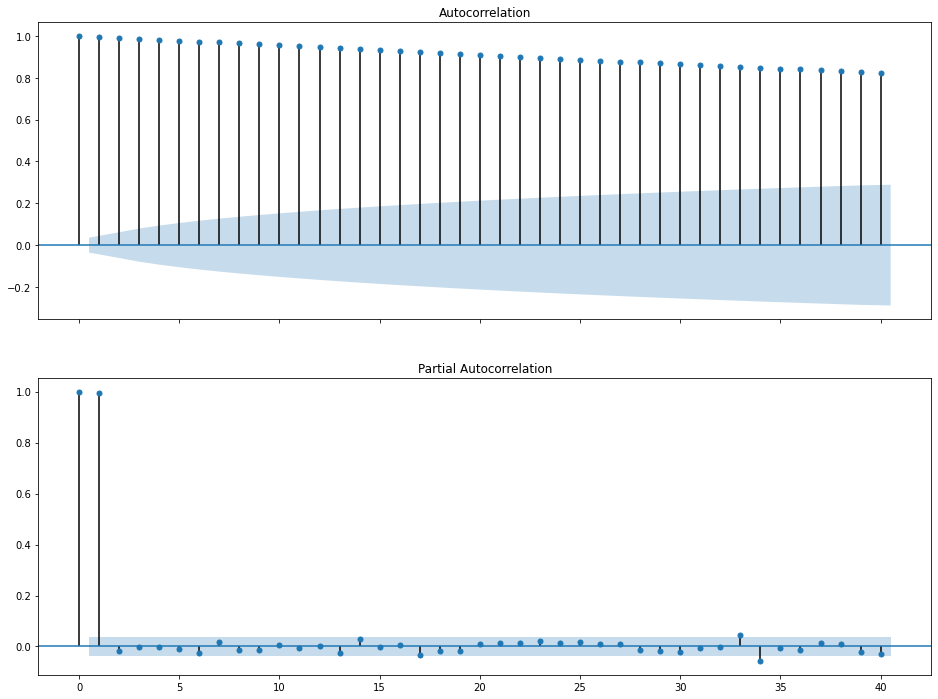

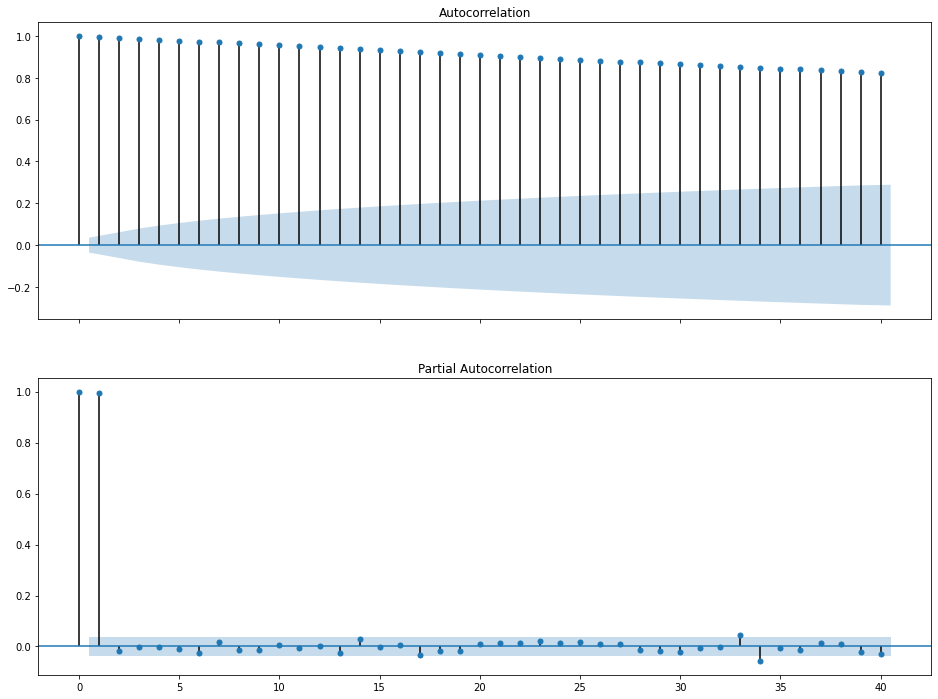

In [145]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
plot_acf(df.y, ax=ax[0], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.y, ax=ax[1], lags=N_LAGS,
 alpha=SIGNIFICANCE_LEVEL)